In [ ]:
hsvImage = rgb2hsv(rgbImage);
hImage = hsvImage(:, :, 1);
sImage = hsvImage(:, :, 2);
vImage = hsvImage(:, :, 3);
figure;
subplot(2,2,1);
hHist = histogram(hImage);
subplot(2,2,2);
sHist = histogram(sImage);
subplot(2,2,3);
vHist = histogram(vImage);

In [ ]:
import cv2
import matplotlib.pyplot as plt
import glob

def path_to_images(path):
    
     for idx,file in enumerate(glob.glob(path)):
        img = cv2.imread(file)


        b, g, r = img[:,:,0], img[:,:,1], img[:,:,2]
        hist_b = cv2.calcHist([b],[0],None,[256],[0,256])
        hist_g = cv2.calcHist([g],[0],None,[256],[0,256])
        hist_r = cv2.calcHist([r],[0],None,[256],[0,256])
        plt.plot(hist_r, color='r', label="r")
        plt.plot(hist_g, color='g', label="g")
        plt.plot(hist_b, color='b', label="b")
        plt.legend(idx)
        plt.show() 

        img2 = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        h, s, v = img[:,:,0], img[:,:,1], img[:,:,2]
        hist_b = cv2.calcHist([b],[0],None,[256],[0,256])
        hist_g = cv2.calcHist([g],[0],None,[256],[0,256])
        hist_r = cv2.calcHist([r],[0],None,[256],[0,256])
        plt.plot(hist_h, color='r', label="h")
        plt.plot(hist_s, color='g', label="s")
        plt.plot(hist_v, color='b', label="v")
        plt.legend(idx)
        plt.show() 

        img3 = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        h, s, l = img2[:,:,0], img2[:,:,1], img2[:,:,2]
        hist_h = cv2.calcHist([h],[0],None,[256],[0,256])
        hist_s = cv2.calcHist([s],[0],None,[256],[0,256])
        hist_l = cv2.calcHist([v],[0],None,[256],[0,256])
        plt.plot(hist_h, color='r', label="h")
        plt.plot(hist_s, color='g', label="s")
        plt.plot(hist_v, color='b', label="l")
        plt.legend(idx)
        plt.show()
    
if __name__ == '__main__':
    path_to_images('/home/roopesh/Desktop/hsl_mask/*jpg')
 
    

In [3]:
import cv2
from pathlib import Path
import cv_exp.basic
import cv_exp.basic as cv
import cv_exp.pupil_detection as pupil_detection
import cv_exp.draw as draw
import cv_exp.log as log
import cv_exp.take as take
import numpy as np
import glob
import warnings
warnings.filterwarnings("ignore")
import pandas as pd

# Load Specific Tf Model from its path
model_face_detection = '/home/roopesh/Desktop/MediaPipe/cv-exp-framework-master/data/models/face_detection_front.tflite'
model_face_landmarks ='/home/roopesh/Desktop/MediaPipe/cv-exp-framework-master/data/models/face_landmark.tflite'
model_iris_landmarks = '/home/roopesh/Desktop/MediaPipe/cv-exp-framework-master/data/models/iris_landmark.tflite'


iris_detector = pupil_detection.IrisDetectorMP(model_face_detection_path=model_face_detection,
                                                   model_face_landmarks_path=model_face_landmarks,
                                                   model_iris_landmarks_path=model_iris_landmarks)

def path_to_images(path):

    '''
    This function takes the path of the folder containing the images and returns the csv file of each image
    :param path: Path of the folder containing the images
    :return: Resized1( which is the path of the Folder containing csv {RGB pixels} of each image)
    '''

    for idx,file in enumerate(glob.glob(path)):
        images = cv2.imread(file)

# conversion numpy array into rgb image to show

        image_bgr_rgb = cv2.cvtColor(images, cv2.COLOR_BGR2RGB)
        image_rgb_bgr = cv2.cvtColor(image_bgr_rgb, cv2.COLOR_RGB2BGR)
        image_bgr_hsv= cv2.cvtColor(image_rgb_bgr, cv2.COLOR_BGR2HLS) # convert to hsv cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        out = image_bgr_hsv.copy()
        out_pupile = image_bgr_hsv.copy()

        detected_pupils, result = iris_detector.detect(image_bgr_hsv)


        if detected_pupils.is_ok():
            out_pupiles = draw.draw_pupils(out_pupile, detected_pupils.left, detected_pupils.right, )

        if result is not None:
            (face_detection, face_keypoints, face_landmarks,
                left_iris_landmarks, left_eyelid_landmarks,
                right_iris_landmarks, right_eyelid_landmarks,
                left_iris_segmentation, right_iris_segmentation,
                concat_landmarks) = result
            out = draw.draw_contour(out, left_iris_segmentation, thickness=1, color=(0, 255, 0))
            out = draw.draw_contour(out, right_iris_segmentation, thickness=1, color=(0, 255, 0))

            # print('index of IMG', idx)
            a = [(point.x, point.y) for point in left_iris_landmarks]
            c=(np.round(a[0]))
            for left_x,left_y in [c]:
                 lx, ly = left_x, left_y

            # b=[[point.x, point.y] for point in right_iris_landmarks]
            # d=(np.round(b[0]))
            # for right_x,right_y in [d]:
            #     rx, ry = right_x, right_y
# Circular mask
            mask = np.zeros(out_pupiles.shape, dtype=np.uint8)
# Right_iris
#             pt= cv.Point
#             center= (int(right_x),int(right_y))
#             radius =(6)
#             right_mask = cv2.circle(mask, center, radius,(255,255,255), -1 )

# Left_iris
            center= (int(left_x),int(left_y))
            radius =(13)
            left_mask = cv2.circle(mask, center, radius,(255,255,255), -1 )

# Creating Masked Image
            result = cv2.bitwise_and(out_pupiles, mask)
            # print('result_ shape',result.shape)

# Color background white
            result[mask==0] = 255 # Optional

# save result of Mask. Give ur Directory path
            cv2.imwrite(f"/home/roopesh/PycharmProjects/test_ready_iris_classification/Ready_Iris_Classification/Result/Result_Mask/image_mask{idx}.jpg",result) # returning result
            cv2.imwrite(f"/home/roopesh/PycharmProjects/test_ready_iris_classification/Ready_Iris_Classification/Result/Result_Out_Pupil/image{idx}.jpg",out_pupiles)

# resize 3d to 2d numpy array
            resized = result
# Dimensions: [m, n, 3]
            resized = resized.transpose()
# Dimensions: [3, m, n]
            resized = resized.reshape( (resized.shape[1]*resized.shape[2]),resized.shape[0]) # re shaping by multiplying (height*width), channel to make 2d

# Removing White Background Pixels from the Mask Image using pandas
            resized =pd.DataFrame(resized)
            resized1= resized.copy()
            resized1.replace({255: np.nan}, inplace = True)
            resized1.dropna(inplace=True)
            resized1.astype('int')

# Saving CSV file based on each Image Numbered as (idx)

            resized1.to_csv(f'/home/roopesh/PycharmProjects/test_ready_iris_classification/Ready_Iris_Classification/Result/Multiple_CSV/CSV-{idx}.csv', sep=',',index=False,header=False)

    print('MediaPipe Processeing Done')
    return resized1




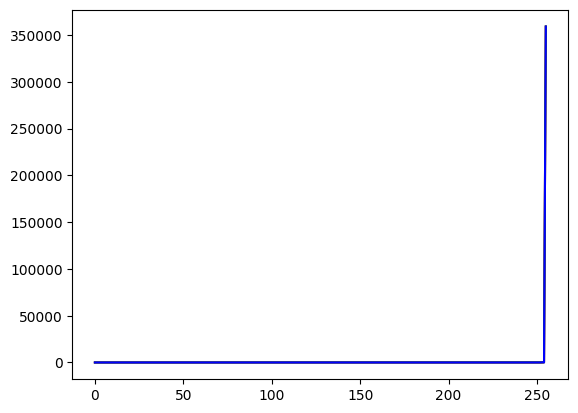

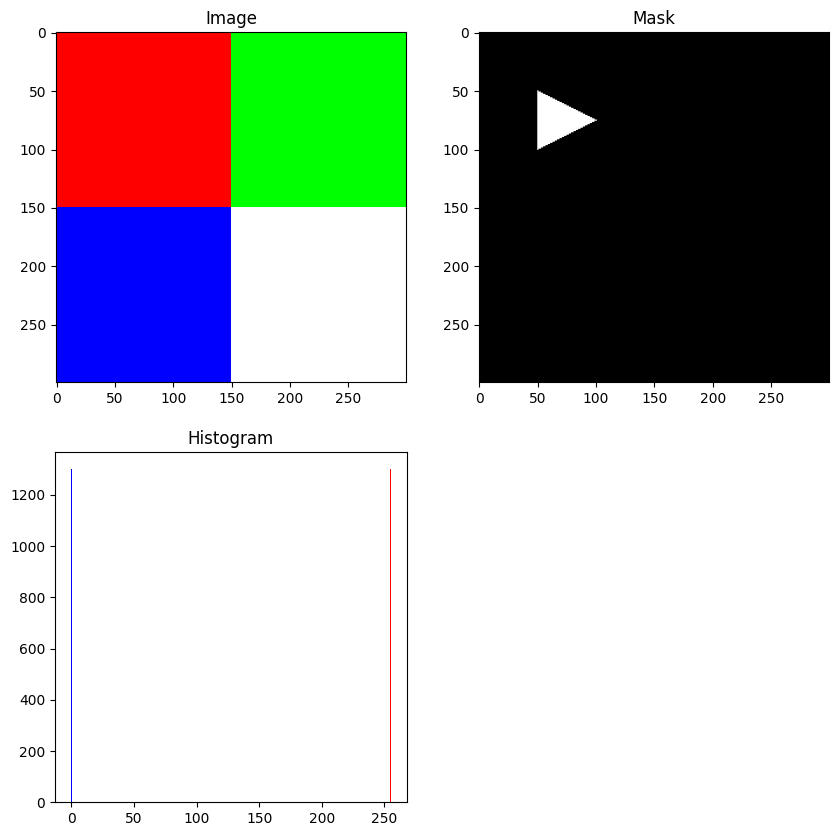

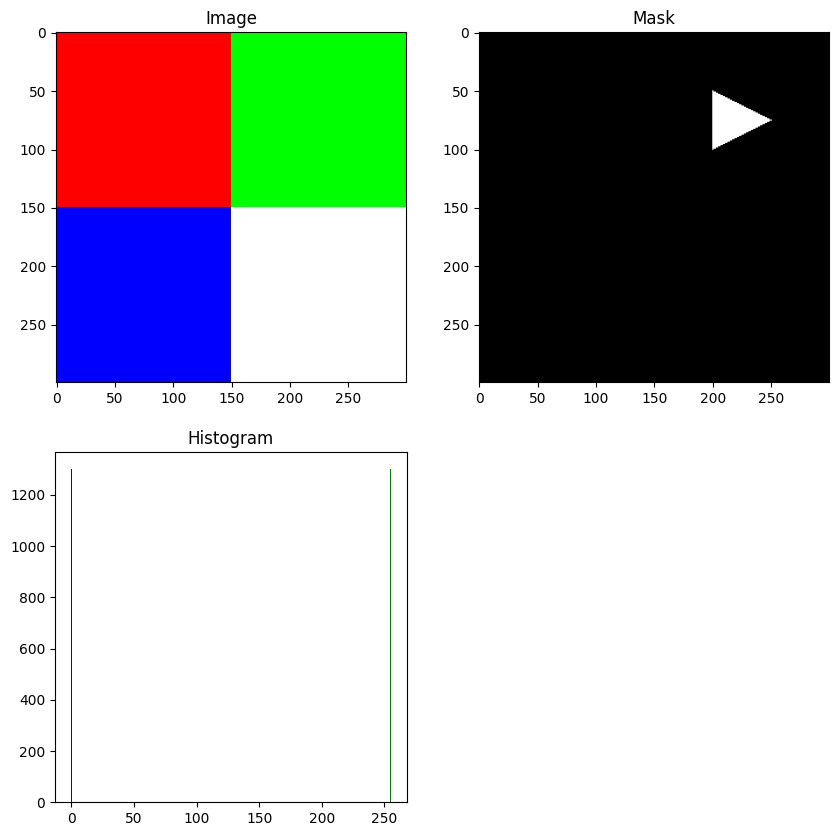

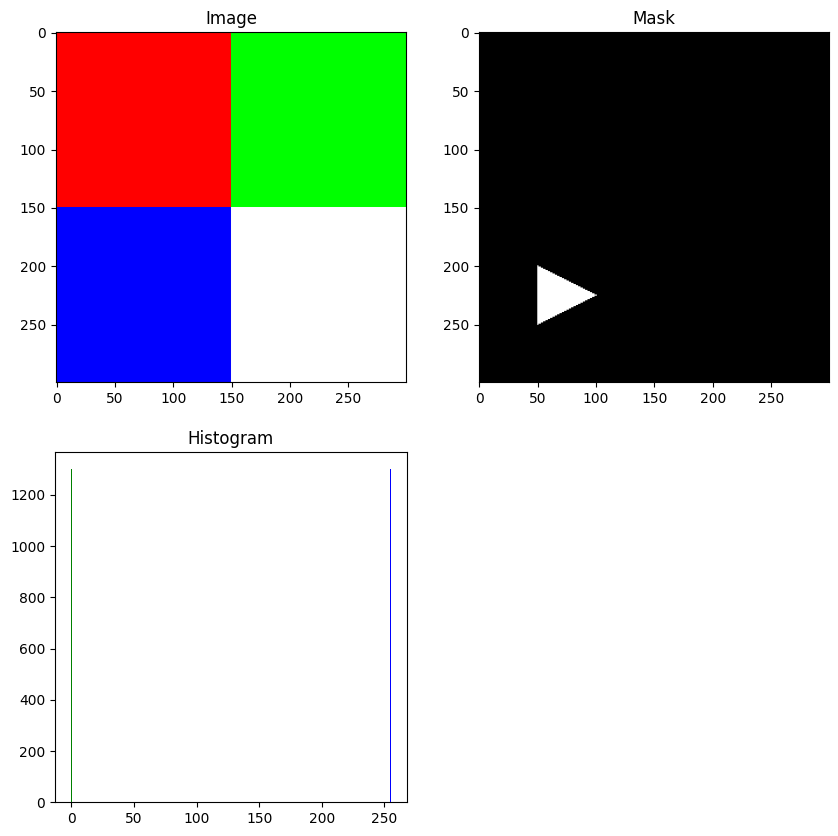

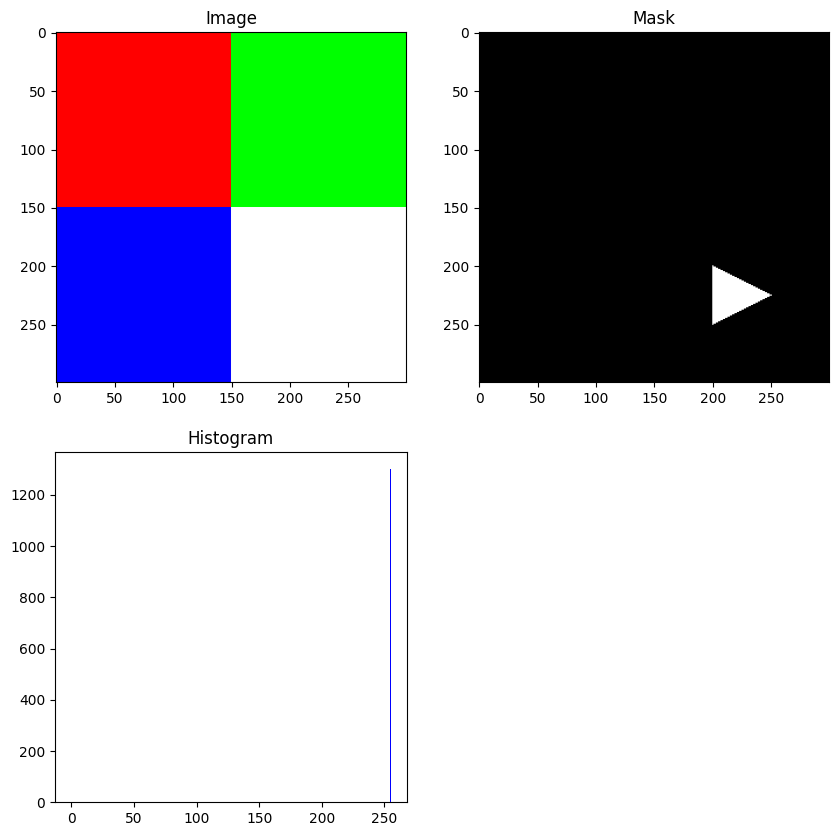

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import face
from PIL import Image, ImageDraw

# Let's create test image with different colors
img = np.zeros((300, 300, 3), dtype=np.uint8)
img[0:150, 0:150] = [255, 0, 0]
img[0:150, 150:] = [0, 255, 0]
img[150:, :150] = [0, 0, 255]
img[150:, 150:] = [255, 255, 255]

# define our function for preparing mask
def prepare_mask(polygon, image):
    """Returns binary mask based on input polygon presented as list of coordinates of vertices
    Params:
        polygon (list) - coordinates of polygon's vertices. Ex: [(x1,y1),(x2,y2),...] or [x1,y1,x2,y2,...]
        image (numpy array) - original image. Will be used to create mask of the same size. Shape (H, W, C).
    Output:
        mask (numpy array) - boolean mask. Shape (H, W).
    """
    # create an "empty" pre-mask with the same size as original image
    width = image.shape[1]
    height = image.shape[0]
    mask = Image.new('L', (width, height), 0)
    # Draw your mask based on polygon
    ImageDraw.Draw(mask).polygon(polygon, outline=1, fill=1)
    # Covert to np array
    mask = np.array(mask).astype(bool)
    return mask


def compute_histogram(mask, image):
    """Returns histogram for image region defined by mask for each channel
    Params:
        image (numpy array) - original image. Shape (H, W, C).
        mask (numpy array) - boolean mask. Shape (H, W).
    Output:
        list of tuples, each tuple (each channel) contains 2 arrays: first - computed histogram, the second - bins.

    """
    # Apply binary mask to your array, you will get array with shape (N, C)
    region = image[mask]

    red = np.histogram(region[..., 0].ravel(), bins=256, range=[0, 256])
    green = np.histogram(region[..., 1].ravel(), bins=256, range=[0, 256])
    blue = np.histogram(region[..., 2].ravel(), bins=256, range=[0, 256])

    return [red, green, blue]


def plot_histogram(histograms):
    """Plots histogram computed for each channel.
    Params:
        histogram (list of tuples) - [(red_ch_hist, bins), (green_ch_hist, bins), (green_ch_hist, bins)]
    """

    colors = ['r', 'g', 'b']
    for hist, ch in zip(histograms, colors):
        plt.bar(hist[1][:256], hist[0], color=ch)

# Create some test masks
red_polygon = [(50, 100), (50, 50), (100, 75)]
green_polygon = [(200, 100), (200, 50), (250, 75)]
blue_polygon = [(50, 250), (50, 200), (100, 225)]
white_polygon = [(200, 250), (200, 200), (250, 225)]
polygons = [red_polygon, green_polygon, blue_polygon, white_polygon]

for polygon in polygons:
    mask = prepare_mask(polygon, img)
    histograms = compute_histogram(mask, img)

    # Let's plot our test results
    plt.figure(figsize=(10, 10))

    plt.subplot(221)
    plt.imshow(img)
    plt.title('Image')

    plt.subplot(222)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')


    plt.subplot(223)
    plot_histogram(histograms)
    plt.title('Histogram')

    plt.show()

In [ ]:
import numpy as np
import cv2

image = cv2.imread('/home/roopesh/PycharmProjects/test_ready_iris_classification/Ready_Iris_Classification/Result/Result_Mask/image_mask0.jpg')
y=0
x=0
h=100
w=200
crop = image[y:y+h, x:x+w]
cv2.imshow('Image', crop)
cv2.waitKey(0) 

In [44]:
import os
import cv2
import numpy as np

def path_to_images(path):
    
    files = os.listdir(files_dir)
    sorted_images = sorted(files, key=lambda x:int(x[5:-4]))

    for idx, f in enumerate(sorted_images):
        if f.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = files_dir + '/' + f

            image= cv2.imread(image_path)

            cv2.imwrite(f"/home/roopesh/Desktop/ze/image{idx}.jpg",image)

    #     print( file)
if __name__=='__main__':
    files_dir = os.getcwd() + '/Desktop/HSL/Human_Iris_Dataset/'
    path_to_images(files_dir)

In [45]:
import os
import cv2
import numpy as np

def path_to_images(path):
    
    files = os.listdir(files_dir)
    sorted_images = sorted(files, key=lambda x:int(x[5:-4]))

    for idx, f in enumerate(sorted_images):
        if f.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = files_dir + '/' + f

            image= cv2.imread(image_path)

            cv2.imwrite(f"/home/roopesh/Desktop/ze/image{idx}.jpg",image)

    #     print( file)
if __name__=='__main__':
    files_dir = os.getcwd() + '/Desktop/HSL/Human_Iris_Dataset/'
    path_to_images(files_dir)
    print(files_dir)

/home/roopesh/Desktop/HSL/Human_Iris_Dataset/
